# Run the Python version of SOLID

Install SOLID.

In [ ]:
!python -m pip install git+https://github.com/BrandonSmithJ/MDN
!pip install matplot -U
!pip uninstall -y keras-nightly~=2.5.0.dev
!pip install keras==2.3.1

Import libraries.

In [34]:
from MDN.benchmarks.tss.SOLID.model import model as SOLID
from MDN import get_tile_data, image_estimates
 
import matplotlib.pyplot as plt
import numpy as np 

Attach Google Drive.

In [22]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import sys
sys.argv=['']
del sys

Setup parameters for SOLID.

In [ ]:
path   = '/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc'
sensor = 'MSI'

     # Extract relevant wavelengths and respective Rrs from the netcdf
wavelengths, Rrs = get_tile_data(path, sensor, allow_neg=False) 
print(f'Wavelengths: {wavelengths}  Rrs shape: {Rrs.shape}')

    # Apply SOLID to the extracted Rrs
MDN_kwargs = {
   'verbose'    : True,  # Whether to shown progress through bagging rounds
   'use_gpu'    : False, # Whether to run predictions on /gpu:0, if available.
   'chunk_size' : None,  # Number of samples the model is applied to at one time. None indicates full set is estimated at once.
}



Run SOLID and plot predictions.

In [ ]:
tss = image_estimates(Rrs, function=SOLID, wavelengths=wavelengths, sensor=sensor, **MDN_kwargs)
print(f'TSS shape: {tss.shape}')
 
plt.imshow(np.squeeze(tss), vmin=0, vmax=100)
plt.colorbar()
plt.title('2018-12-27 : MSI @ 60m')
plt.gca().tick_params(labelcolor='none', bottom=False, left=False)
#plt.savefig('SOLID_20181227.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Prepare input file for Earth Engine

Netcdf file has to be converted to geotiff before it can be uploaded to Earth Engine. We use gdal to convert it.




In [39]:
from osgeo import gdal, osr, gdal_array
import numpy as np
import pandas as pd

Inspect netcdf file

In [ ]:
ds = gdal.Open(path)
for item in ds.GetSubDatasets():
    print(item[0])
    index = item[0].rfind(':') + 1
    print(item[0][index:])

Find geo transform by reading lon and lat values from netcdf file.

In [ ]:
subset = gdal.Open('NETCDF:"/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc":lon')

print(f'shape: {subset.ReadAsArray().shape}')
print(f'rasterXSize: {subset.RasterXSize}')
print(f'rasterYSize: {subset.RasterYSize}')

lngmin  = subset.ReadAsArray()[0,0]
lngmax = subset.ReadAsArray()[subset.RasterYSize - 1, subset.RasterXSize - 1]
print(f'longitude min: {lngmin}')
print(f'longitude max: {lngmax}')

subset = gdal.Open('NETCDF:"/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc":lat')
latmin  = subset.ReadAsArray()[0,0]
latmax = subset.ReadAsArray()[subset.RasterYSize - 1, subset.RasterXSize - 1]
print(f'latitude min: {latmin}')
print(f'latitude max: {latmax}')

transform = (lngmin, (lngmax - lngmin) / subset.RasterXSize, 0.0, latmin, 0.0, (latmax - latmin) / subset.RasterYSize)
print(f'geo transform: {transform}')


Define method for converting to geotiff.

In [42]:
import os

def create_geotiff(suffix, input_file, result, geot):
    # Get subdatasets 
    ds = gdal.Open(input_file)
    subsets = ds.GetSubDatasets()

    # Read the first one 
    sub_ds = gdal.Open(subsets[0][0])
    xsize = sub_ds.RasterXSize
    ysize = sub_ds.RasterYSize
    data = sub_ds.ReadAsArray(0, 0, xsize, ysize)
    dt = gdal_array.NumericTypeCodeToGDALTypeCode(data.dtype)
    if type(dt) != np.int:
        if dt.startswith('gdal.GDT_') is False:
            dt = eval('gdal.GDT_'+dt)
    new_fname = suffix + '.tif'
    
    # Define projection
    proj = osr.SpatialReference()
    proj.SetWellKnownGeogCS('WGS84')

    driver = gdal.GetDriverByName('GTiff')
    zsize = len(subsets) + 1
    ds = driver.Create(new_fname, xsize, ysize, zsize, dt)
    ds.SetProjection(proj.ExportToWkt())
    ds.SetGeoTransform(geot)

    for index in range(0, len(subsets) - 1):
      subset = gdal.Open(subsets[index][0])
      data = subset.ReadAsArray(0, 0, xsize, ysize)
      ndv = subset.GetRasterBand(1).GetNoDataValue()
      d = data
#      d = np.flip(data, 0)
      d[np.isnan(d)] = ndv
      ds.GetRasterBand(index + 1).WriteArray(d)
      ds.GetRasterBand(index + 1).SetNoDataValue(ndv)
      print(f'(Writing band: {subsets[index][0]}')

    d = np.flip(result, 0)
    subset = gdal.Open(subsets[2][0])
    d[np.isnan(d)] = subset.GetRasterBand(1).GetNoDataValue()
    ds.GetRasterBand(len(subsets) + 1 ).WriteArray(d)
    ds.GetRasterBand(len(subsets) + 1).SetNoDataValue(ndv)
    print(f'(Writing band tss')

    ds.FlushCache()
    return new_fname

Convert prediction result to geotiff and write it to google drive.




In [ ]:
#subset = gdal.Open('NETCDF:"/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc":Rrs_443')
#ndv, xs, ys, geot, proj = get_netcdf_info(path, 'Rrs_443')

outdir = '/content/drive/MyDrive'
outname = 'geotiff'
#create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), subset.ReadAsArray()[0:1069, 0: 805], ndv, xs, ys, transform, proj)
#create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), tss[:,:,0], ndv, xs, ys, transform)#
create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), path, tss[:,:,0], transform)

File has to be uploaded to Google bucket first before uploading it to Earth Engine. Login to Google Cloud.

In [ ]:
!gcloud auth login 

Upload file to bucket. Change the bucket name to your bucket.

In [ ]:
BUCKET = 'YOUR_BUCKET_NAME'
GS_URL = 'gs://' + BUCKET + '/geotiff.tiff'
!gsutil cp '/content/drive/MyDrive/out_geotiff.tif' {GS_URL}

Check file has been uploaded. 

In [ ]:
!gsutil ls -l {GS_URL}

Sign in to Earth Engine.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

Upload file to Earth Engine from Google Cloud Storage. Change the ASSET_ID to your asset id.

In [ ]:
import json
ASSET_ID = 'YOUR_EARTH_ENGINE_ASSET_ID'
manifest = {
  "name": "projects/earthengine-legacy/assets/" + ASSET_ID,
  "tilesets": [
    {
      "sources": [
        {
          "uris": [
            GS_URL
          ]
        }
      ]
    }
  ]
}
ds = gdal.Open(path)
bands = []
ind = 0
print("Writing bands:")
for item in ds.GetSubDatasets():
    index = item[0].rfind(':') + 1
    band = item[0][index:]
    print(band)
    bands.append({"id": band, "tileset_band_index": ind})
    ind += 1

bands.append({"id": "tss", "tileset_band_index": ind})
print("tss")
manifest["bands"] = bands
MANIFEST_FILE = outdir + "/maifest.json"
f = open(MANIFEST_FILE, "w")
f.write(json.dumps(manifest))
f.close()

!earthengine upload image --manifest {MANIFEST_FILE}

Check upload job.

In [ ]:
ee.batch.Task.list()[0]

Now that results are available in Earth Engine show it on map.


In [ ]:
import folium
image = ee.Image(ASSET_ID)
vis = {
  'bands': ['tss'],
  'min': 0,
  'max': 100,
  'palette': ['081d58','253494','225ea8','1d91c0','41b6c4','7fcdbb','c7e9b4','edf8b1','ffffd9']
}
map_id = image.getMapId(vis)
map = folium.Map(location=[39.279839, -76.31669])
folium.TileLayer(
  tiles=map_id['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='Prediction for TSS',
).add_to(map)
geometry = ee.Geometry.Polygon([[[-76.10,39.38],[-76.10,39.40],
                                [-76.06, 39.40], [-76.06,39.38],
                                [-76.10,39.38]]])
folium.GeoJson(data=geometry.getInfo(), name='Geometry', overlay=True).add_to(map)
map.add_child(folium.LayerControl())

display(map)

# Use Earth Engine asset as input to calculation
Now, that we have imported the input image to EE, we try to use the image to do the calculation. We convert each band to a numpy array and stack them to a 3 dim tensor. 



In [ ]:
# Convert image bands to numpy arrays in selected rectangle
bands = [443, 492, 560, 665, 704, 740, 783] 
image_array = []
for i in range(len(bands)):
    band = 'Rrs_' + str(bands[i])
    array = image.select(band).sampleRectangle(region=geometry)
    array = array.getInfo().get('properties').get(band)
    np_array = np.array(array)
    image_array.append(np_array)
    print(np_array.shape)

In [ ]:
# stack array together to a 3 dim tensor, 3rd dimension = band
stack = np.ma.stack(image_array, axis=2)
stack.shape

In [ ]:
# Run the calculation on this tensor
tss = image_estimates(stack, function=SOLID, wavelengths=bands, sensor=sensor, **MDN_kwargs)

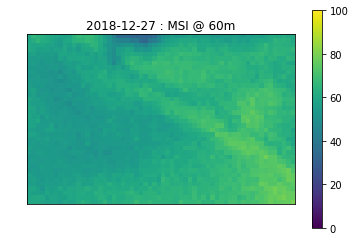

In [55]:
# Show result
plt.imshow(np.squeeze(tss), vmin=0, vmax=100)
plt.colorbar()
plt.title('2018-12-27 : MSI @ 60m')
plt.gca().tick_params(labelcolor='none', bottom=False, left=False)
#plt.savefig('SOLID_20181227.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Running SOLID on a sentinel image from in EE
Let's try the calculation on an sentinel image from EE, the bands are B1 to B7. We choos an image which covers the selected geometry. 

In [ ]:
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] 
sentinel_image = ee.Image('COPERNICUS/S2_SR/20200116T155609_20200116T155605_T18SUJ');

image_array = []
for i in range(len(bands)):
    array = sentinel_image.select(band_names[i]).sampleRectangle(region=geometry)
    array = array.getInfo().get('properties').get(band_names[i])
    np_array = np.array(array)
    np_array = np.resize(np_array, (38, 59))
    image_array.append(np_array)
    print(np_array.shape)

In [ ]:
stack = np.ma.stack(image_array, axis=2)
stack.shape

In [ ]:
# Run the calculation
tss = image_estimates(stack, function=SOLID, wavelengths=bands, sensor=sensor, **MDN_kwargs)

# [WIP] Attempt at getting rioxarray to work...

In [ ]:
!pip install rioxarray

In [ ]:
import xarray
import rioxarray
import rasterio

In [ ]:
xds = xarray.open_dataset(
    "/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc",
    decode_coords="all"
)

In [ ]:
xds

In [ ]:
xds = xds.rename({'lon':'x', 'lat':'y'})

In [ ]:
xds

In [ ]:
xds.rio.set_spatial_dims('x', 'y', inplace=True)

In [ ]:
xds.rio.write_crs("epsg:4326", inplace=True)

In [ ]:
xds.rio.write_transform(
    rasterio.Affine(lngmin,
                    (lngmax - lngmin) / subset.RasterXSize,
                    0.0,
                    latmin,
                    0.0,
                    (latmax - latmin) / subset.RasterYSize)
)

In [ ]:
xds.rio.crs

Convert each of the bands to GeoTIFF files.

In [ ]:
[band for band in xds.variables]

In [ ]:
for band in xds.variables:
  if band.startswith('Rrs_'):
    print(band)
    xds[band].rio.to_raster(f'{band}.tif')

# Start building SOLID with S2 SR while Acolite version is sorted


In [ ]:
!pip install geemap --quiet

In [ ]:
import geemap

In [ ]:
Map = geemap.Map(center=[42,-71], zoom= 9)
Map

Get s2 sr imagery for Narragansett Bay region

In [ ]:
import ee
NBay = ee.Geometry.Polygon(
        [[[-71.44643316430347, 41.92140472212022],
          [-71.53981695336597, 41.48257061731345],
          [-71.47939214867847, 41.3383770483458],
          [-71.16078863305347, 41.42699101424345],
          [-71.16095830370352, 41.64257191827559],
          [-70.97676763695972, 41.88869830740288],
          [-71.15111544654354, 41.97883748042962]]])

imageVisParam = {"opacity":1,"bands":["B4","B3","B2"],"min":-560.1588934829267,"max":2614.3187289464204,"gamma":1}

In [ ]:

area=NBay
#Time window
startyear = 2020
endyear = 2020;
startmonth = 1
endmonth = 12

imageCollection = ee.ImageCollection("COPERNICUS/S2_SR")\
  .filterBounds(area)\
  .filter(ee.Filter.lt('HIGH_PROBA_CLOUDS_PERCENTAGE',50))\
  .filter(ee.Filter.calendarRange(startyear,endyear,'year'))\
  .filter(ee.Filter.calendarRange(startmonth,endmonth,'month'))\
  .sort('system:time_start')\
  .set('SENSOR_ID', 'OLI_TIRS')

#old s2 cloudmask and water, there is a different new one, but keeping it simple
def cloudmask(img):
                  mask = img.select(['SCL']).eq(6)
                  notcloud=img.select(['QA60']).eq(0)
                  img=img.updateMask(mask)
                  img=img.updateMask(notcloud)
                  return img

imageCollection = imageCollection.map(cloudmask)

#Map.addLayer(imageCollection.median(),imageVisParam,"result1")

Keep just one image to learn on and classify the "type" of SOLID water


In [ ]:
image = ee.Image(imageCollection.sort('HIGH_PROBA_CLOUDS_PERCENTAGE').first());
Map.addLayer(imageCollection.median(),imageVisParam,"image")



Create water type from band rules from SOLID

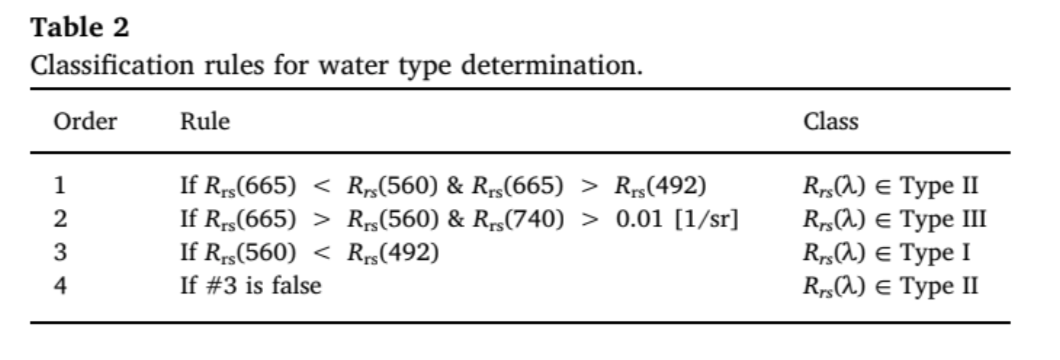


In [ ]:
# B4 - R(665)
# B3 - R(560)
# B2 - R(492)
# B6 - R(740)

def watertype(img): 
  b4 = img.select("B4")
  b3 = img.select("B3")
  b2 = img.select("B2")
  b6 = img.select("B6")
  
  typeII = b4.lt(b3).And(b4.gt(b2)
  
  return img.addBands(typeII)

 #typeIII= ee.Number(test) #not sure what sr is. Add them all up?  
 # typeI = b3.lt(b2)
 # typeII = 1-typeI
 #img.addBands([typeII,typeIII,typeI,typeII])



